In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import os
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd

In [4]:
# import os
# import numpy as np
# from torch.utils.data import Dataset

# class CustomDataset(Dataset):
#     def __init__(self, root_dir):
#         self.root_dir = root_dir
#         self.class_labels = sorted(os.listdir(root_dir))
#         self.data = []
#         self.target = self.root_dir.split('\\')[-1]
#         self.target_map = {"squat": 0, "deadlift": 1}
        
#         for label_idx, label in enumerate(self.class_labels):
#             label_dir = os.path.join(root_dir, label)
#             for subdir, _, files in os.walk(label_dir):
#                 for file in files:
#                     if file.endswith('.npz'):
#                         file_path = os.path.join(subdir, file)
#                         self.data.append(file_path)
#                         self.targets.append(label_idx)
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, index):
#         file_path = self.data[index]
#         target = self.targets[index]
        
#         data = np.load(file_path)
#         # Assuming the data in the .npz file is stored in a variable named 'data'
#         data = data['reconstruction'][:, 5:, :2]
        
#         last_row = data[-1]

#         # Pad the data to a fixed length
#         # fixed_length = 278
#         # if len(data) < fixed_length:
#         #     data = np.concatenate([data, np.tile(last_row, (fixed_length - len(data), 1))])
#         # else:
#         #     data = data[:fixed_length]
#         return data, target


In [5]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.file_paths = self._get_file_paths()

    def _get_file_paths(self):
        file_paths = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            files = os.listdir(class_dir)
            for file in files:
                file_paths.append((os.path.join(class_dir, file), label))
        return file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path, label = self.file_paths[idx]
        data = np.load(file_path)
        data = data['reconstruction'][:, :, :2]
        # Pad the data to a fixed length
        last_row = np.expand_dims(data[-1], 0)
        fixed_length = 150
        if len(data) < fixed_length:
            data = np.concatenate([data, np.tile(last_row, (fixed_length - len(data), 1, 1))])
        else:
            data = data[:fixed_length]
        features = torch.from_numpy(data).float()  # Assuming features are stored under the key 'features'
        return features, label

In [83]:
data = CustomDataset(r"new_keypoints_30_03")
print(len(data))

182


In [84]:
tmp = next(iter(data))
print(tmp[0].shape, tmp[1])

torch.Size([150, 17, 2]) 0


In [8]:
next(iter(data))[0].shape, next(iter(data))[1]

(torch.Size([150, 17, 2]), 0)

In [20]:
# use the DataLoader class to load the data
from torch.utils.data import DataLoader

batch_size = 16
shuffle = True

squats_loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)

# Example usage
for batch in squats_loader:
    features, labels = batch
    print(features.shape, labels.shape)
    break

print(labels)

torch.Size([16, 150, 17, 2]) torch.Size([16])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0])


In [9]:
class TCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.input_size = input_size
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.conv_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()
        self.num_layers = len(num_channels)

        # Modified here
        in_channels = input_size[-1]

        for i in range(self.num_layers):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation // 2

            out_channels = num_channels[i]
            conv_layer = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
            self.conv_layers.append(conv_layer)
            batch_norm_layer = nn.BatchNorm1d(out_channels)
            self.batch_norm_layers.append(batch_norm_layer)

            in_channels = out_channels

        self.linear = nn.Linear(num_channels[-1], 3)
        self.dropout_layer = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_poses, num_joints, num_coords = x.size()
        x = x.reshape(batch_size, num_poses * num_joints, num_coords).transpose(1, 2)
        for i in range(self.num_layers):
            conv_layer = self.conv_layers[i]
            batch_norm_layer = self.batch_norm_layers[i]
            x = conv_layer(x)
            x = batch_norm_layer(x)
            x = nn.functional.relu(x)
            x = self.dropout_layer(x)
        x = x.mean(dim=2)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [933]:
use_cuda = True

In [27]:
torch.manual_seed(1)
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [32]:
# Train, validation, and test splits
train_size = 100
val_size = 50
test_size = 32

seed = 20

train_data, test_data = train_test_split(data, test_size=test_size, train_size=150, shuffle=True, random_state=seed)
train_data, val_data = train_test_split(train_data, test_size=val_size, train_size=train_size, shuffle=True, random_state=seed)


In [33]:
print(len(train_data), len(val_data))
print(len(test_data))

100 50
32


In [34]:
# write a code to print the number of data in each label of 1 and 0
for i in range(3):
    print(f"Number of data in label {i}: {len([label for _, label in train_data if label == i])}")


Number of data in label 0: 35
Number of data in label 1: 31
Number of data in label 2: 34


In [35]:
for i in range(3):
    print(f"Number of data in label {i}: {len([label for _, label in val_data if label == i])}")

Number of data in label 0: 18
Number of data in label 1: 18
Number of data in label 2: 14


In [36]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=4, shuffle=True)

In [22]:
def get_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    return correct / total

In [974]:
import os
import torch.nn.utils as utils

def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=30):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    model.to(device)

    prev_loss = 10000
    save_models = './saved_models_150'  # Define the path to save models
    os.makedirs(save_models, exist_ok=True)  # Create the directory if it doesn't exist

    for epoch in range(n_epochs):
        model.train()
        
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            loss.backward()
            utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)
        train_acc = get_accuracy(model, train_loader, device)
        train_acc_history.append(train_acc)

        
        val_loss = 0.0

        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc = get_accuracy(model, val_loader, device)
        val_acc_history.append(val_acc)        

        scheduler.step(val_loss)
        
        if val_loss < prev_loss:
            prev_loss = val_loss
            path2save = os.path.join(save_models, f"model_e{epoch+1}_l{val_loss:.4f}.pth")
            torch.save(model.state_dict(), path2save)
            print(f"Model saved in {path2save}")
        
        print(f'Epoch {epoch+1}/{n_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
        print(f'Train Accuracy = {train_acc:.4f}, Val Accuracy = {val_acc:.4f}')
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [37]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = TCN(input_size=(150, 17 ,2), num_channels=[8, 8, 8, 8], kernel_size=3, dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, amsgrad=True)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.90)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss() 

c:\Users\Akshith\anaconda3\envs\vitpose\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [982]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(model, train_dl, val_dl, optimizer, scheduler, criterion, device, 100)

Model saved in ./saved_models_150\model_e1_l1.1001.pth
Epoch 1/100: Train Loss = 1.1024, Val Loss = 1.1001
Train Accuracy = 0.3100, Val Accuracy = 0.3200
Model saved in ./saved_models_150\model_e2_l1.0972.pth
Epoch 2/100: Train Loss = 1.0911, Val Loss = 1.0972
Train Accuracy = 0.4100, Val Accuracy = 0.4000
Epoch 3/100: Train Loss = 1.0787, Val Loss = 1.0981
Train Accuracy = 0.4300, Val Accuracy = 0.3400
Model saved in ./saved_models_150\model_e4_l1.0933.pth
Epoch 4/100: Train Loss = 1.0723, Val Loss = 1.0933
Train Accuracy = 0.5200, Val Accuracy = 0.3600
Model saved in ./saved_models_150\model_e5_l1.0847.pth
Epoch 5/100: Train Loss = 1.0645, Val Loss = 1.0847
Train Accuracy = 0.5500, Val Accuracy = 0.4200
Model saved in ./saved_models_150\model_e6_l1.0740.pth
Epoch 6/100: Train Loss = 1.0540, Val Loss = 1.0740
Train Accuracy = 0.5700, Val Accuracy = 0.4800
Model saved in ./saved_models_150\model_e7_l1.0662.pth
Epoch 7/100: Train Loss = 1.0368, Val Loss = 1.0662
Train Accuracy = 0.6000,

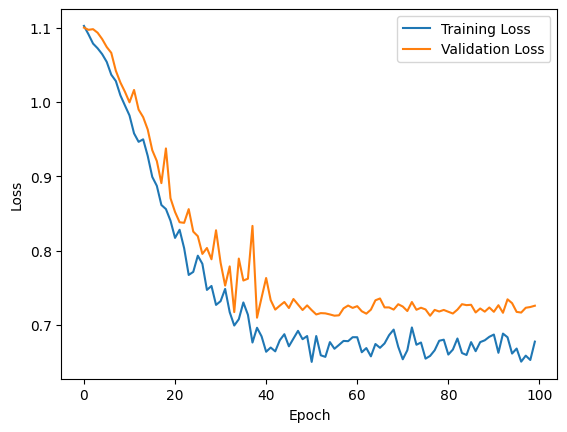

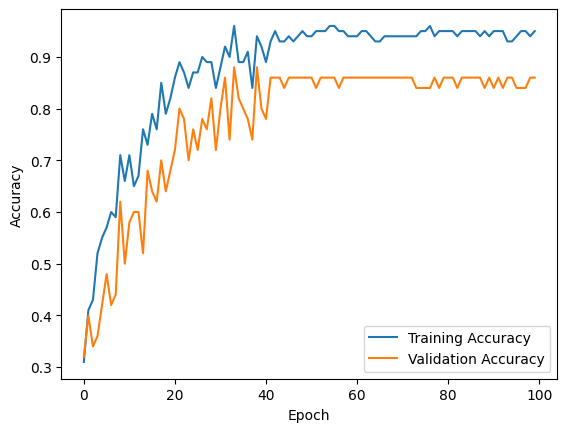

In [983]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
def inference(model, data_loader, device):
    predictions = []
    labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels_batch in data_loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())
    return predictions, labels

In [985]:
from sklearn.metrics import classification_report
train_predictions, train_labels = inference(model, train_dl, device)
val_predictions, val_labels = inference(model, val_dl, device)

# Compute classification report for train and val datasets
train_report = classification_report(train_labels, train_predictions)
val_report = classification_report(val_labels, val_predictions)

print("Classification Report for Train Data:")
print(train_report)
print("Classification Report for Validation Data:")
print(val_report)

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.94      0.97        31
           2       0.94      0.91      0.93        34

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        17
           1       0.94      1.00      0.97        16
           2       1.00      0.59      0.74        17

    accuracy                           0.86        50
   macro avg       0.89      0.86      0.85        50
weighted avg       0.89      0.86      0.85        50



In [986]:
# Save the model checkpoint
torch.save(model.state_dict(), 'tcn_model_ex3_150.pth')


In [687]:
# testdata = CustomDataset(r"test_npz_files")

# # Create DataLoader for test data
# test_dl = DataLoader(testdata, batch_size=4, shuffle=True)

In [78]:
for i in range(3):
    print(f"Number of data in label {i}: {len([label for _, label in test_data if label == i])}")

Number of data in label 0: 8
Number of data in label 1: 11
Number of data in label 2: 13


In [79]:
test_dl = DataLoader(test_data, batch_size=4, shuffle=True)

In [80]:
# test accuracy
model.load_state_dict(torch.load('saved_models_150\model_e39_l0.7096.pth'))

test_acc = get_accuracy(model, test_dl, device)
print(f'Test Accuracy = {test_acc:.4f}')

Test Accuracy = 0.9375


In [88]:
from sklearn.metrics import classification_report

# Assuming your model is named 'model' and you have a test DataLoader named 'test_dl'
# Iterate over test DataLoader to make predictions
model.eval()
all_predictions = []
all_labels = []
misclassified_samples = []  # Initialize list to store misclassified samples
misclassified_labels = [] 
misclassified_predictions = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        print(inputs.shape)
        # Forward pass
        outputs = model(inputs)

        # Convert outputs to predicted labels (e.g., using argmax)
        _, predicted = torch.max(outputs, 1)
        

        # Append predicted labels and ground truth labels to lists
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_samples.append(inputs[i].cpu().numpy())
                misclassified_labels.append(labels[i].cpu().item())
                misclassified_predictions.append(predicted[i].cpu().item())

# Compute classification report
report = classification_report(all_labels, all_predictions)
print(report)


torch.Size([4, 150, 17, 2])
torch.Size([4, 150, 17, 2])
torch.Size([4, 150, 17, 2])
torch.Size([4, 150, 17, 2])
torch.Size([4, 150, 17, 2])
torch.Size([4, 150, 17, 2])
torch.Size([4, 150, 17, 2])
torch.Size([4, 150, 17, 2])
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.92      1.00      0.96        11
           2       1.00      0.85      0.92        13

    accuracy                           0.94        32
   macro avg       0.94      0.95      0.94        32
weighted avg       0.94      0.94      0.94        32



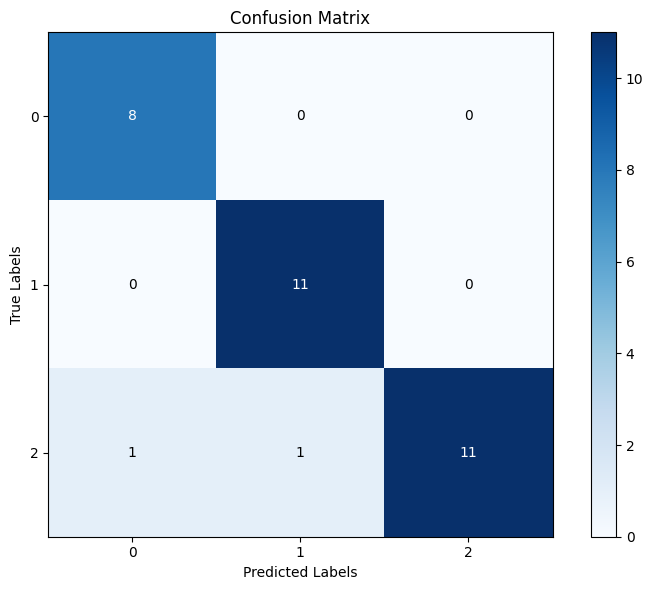

[[ 8  0  0]
 [ 0 11  0]
 [ 1  1 11]]


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(all_labels)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
print(conf_matrix)

In [86]:
for sample, true_label, pred in zip(misclassified_samples, misclassified_labels, misclassified_predictions):
    print("True Label:", true_label)
    print("Predicted Label:", pred)
    print("Misclassified Sample Data:", sample)
    print("-" * 50)  # Separator for clarity

True Label: 2
Predicted Label: 0
Misclassified Sample Data: [[[163.04504 247.69788]
  [150.63751 247.08813]
  [148.08594 243.51233]
  ...
  [512.04663 236.25818]
  [619.9007  141.52075]
  [690.65796 229.93787]]

 [[167.45667 248.56903]
  [154.38525 247.70868]
  [152.05103 243.80548]
  ...
  [511.8587  235.70786]
  [619.2172  141.8844 ]
  [691.8187  230.76877]]

 [[167.61322 248.82315]
  [154.43506 248.72937]
  [151.69696 243.13748]
  ...
  [514.2989  236.63312]
  [620.2706  140.5285 ]
  [692.77734 230.45447]]

 ...

 [[162.51459 255.49597]
  [150.3169  256.43896]
  [148.19415 252.41568]
  ...
  [518.69916 224.49457]
  [625.7087  146.04117]
  [698.16284 236.8689 ]]

 [[168.0498  253.41895]
  [154.55255 254.74023]
  [153.02356 250.82687]
  ...
  [518.127   222.57867]
  [626.5542  145.90308]
  [700.8999  237.24112]]

 [[165.03467 252.67194]
  [151.57104 253.08728]
  [150.35736 249.75555]
  ...
  [516.67554 222.57416]
  [628.8982  147.12186]
  [699.29004 236.53476]]]
----------------------

In [87]:
import os

# Directory containing .npz files
npz_dir = 'new_keypoints_30_03'

# List to store the paths of matched .npz files
matched_files = []

# Iterate over directories containing .npz files
for root, dirs, files in os.walk(npz_dir):
    for file in files:
        if file.endswith('.npz'):
            npz_path = os.path.join(root, file)
            
            # Load .npz file
            npz_data = np.load(npz_path)
            npz_data = npz_data['reconstruction'][:, :, :2]
            # Pad the data to a fixed length
            last_row = np.expand_dims(npz_data[-1], 0)
            fixed_length = 150
            if len(npz_data) < fixed_length:
                npz_data = np.concatenate([npz_data, np.tile(last_row, (fixed_length - len(npz_data), 1, 1))])
            else:
                npz_data = npz_data[:fixed_length]
            
            # Compare npz_data with misclassified data
            # Assuming misclassified_data is a list of misclassified data
            for data, lab, pre in zip(misclassified_samples, misclassified_labels, misclassified_predictions):
                # Check if data matches with npz_data
                if np.all(npz_data == data):
                    matched_files.append(npz_path)
                    print("True Label:", lab, "Predicted Label:", pre)
                    break  # Exit loop if match is found

# Print paths of matched .npz files
for file in matched_files:
    print("Matched .npz file:", file)


True Label: 2 Predicted Label: 1
True Label: 2 Predicted Label: 0
Matched .npz file: new_keypoints_30_03\squats\s_12.npz
Matched .npz file: new_keypoints_30_03\squats\s_42.npz
